In [1]:
from scipy.linalg import svd
import dalex as dx
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lime.lime_tabular
import lime.lime_image
import warnings
import sys

sys.path.append('../')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import shap

plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

warnings.filterwarnings('ignore')
from src import metrics
from sklearn.model_selection import train_test_split, KFold

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, hidden_size, num_classes, num_epochs, batch_size, learning_rate, verbose=True):
        super(NeuralNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.verbose = verbose

        self.fc1 = nn.Linear(30, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def fit(self, X_train, y_train):
        # Convert the data to tensor
        X_train = torch.from_numpy(X_train.values).float()
        y_train = torch.from_numpy(y_train.values).long()

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)

        # Train the model
        for epoch in range(self.num_epochs):
            for i in range(0, X_train.shape[0], self.batch_size):
                # Forward pass
                outputs = self(X_train[i:i + self.batch_size])
                loss = criterion(outputs, y_train[i:i + self.batch_size])

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if self.verbose and (epoch + 1) % 10 == 0:
                print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, self.num_epochs, loss.item()))

    def predict(self, X_test):
        # Convert the data to tensor
        X_test = torch.from_numpy(X_test.values).float()

        # Test the model
        with torch.no_grad():
            outputs = self(X_test)
            _, predicted = torch.max(outputs.data, 1)
        return predicted.numpy()

    def score(self, X_test, y_test):
        X_test = torch.from_numpy(X_test.values).float()
        y_test = torch.from_numpy(y_test.values).long()
        with torch.no_grad():
            outputs = self(X_test)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == y_test).sum().item()
            accuracy = correct / y_test.shape[0]
        return accuracy

In [3]:
df = pd.read_csv('../dataset/breast-cancer-wisconsin-processed.csv')
label = pd.read_csv('../dataset/breast-cancer-wisconsin-processed-label.csv')
data = pd.concat([df, label], axis=1)

# Split the data with stratified sampling
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# model = NeuralNet(hidden_size=100, num_classes=2, num_epochs=100, batch_size=16, learning_rate=0.1)
# Find the best hyperparameters
"""
best_model = None
best_accuracy = 0

for hidden_size in [10, 50, 100, 200]:
    for num_epochs in [100, 200, 300]:
        for batch_size in [16, 32, 64]:
            for learning_rate in [0.01, 0.1, 1]:
                model = NeuralNet(hidden_size=hidden_size, num_classes=2, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, verbose=False)
                model.fit(X_train, y_train)
                accuracy = model.score(X_test, y_test)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model
                    print('Best accuracy: {:.2f}'.format(best_accuracy))
                    print('Best hyperparameters: hidden_size={}, num_epochs={}, batch_size={}, learning_rate={}'.format(hidden_size, num_epochs, batch_size, learning_rate))
"""

"\nbest_model = None\nbest_accuracy = 0\n\nfor hidden_size in [10, 50, 100, 200]:\n    for num_epochs in [100, 200, 300]:\n        for batch_size in [16, 32, 64]:\n            for learning_rate in [0.01, 0.1, 1]:\n                model = NeuralNet(hidden_size=hidden_size, num_classes=2, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, verbose=False)\n                model.fit(X_train, y_train)\n                accuracy = model.score(X_test, y_test)\n                if accuracy > best_accuracy:\n                    best_accuracy = accuracy\n                    best_model = model\n                    print('Best accuracy: {:.2f}'.format(best_accuracy))\n                    print('Best hyperparameters: hidden_size={}, num_epochs={}, batch_size={}, learning_rate={}'.format(hidden_size, num_epochs, batch_size, learning_rate))\n"

In [5]:
model = NeuralNet(hidden_size=100, num_classes=2, num_epochs=100, batch_size=16, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Epoch [10/100], Loss: 0.0757
Epoch [20/100], Loss: 0.0439
Epoch [30/100], Loss: 0.0343
Epoch [40/100], Loss: 0.0290
Epoch [50/100], Loss: 0.0254
Epoch [60/100], Loss: 0.0231
Epoch [70/100], Loss: 0.0213
Epoch [80/100], Loss: 0.0201
Epoch [90/100], Loss: 0.0192
Epoch [100/100], Loss: 0.0183


In [6]:
print('Accuracy: {:.2f}'.format(metrics.accuracy(y_test, y_pred)))
print('Precision: {:.2f}'.format(metrics.precision(y_test, y_pred)))
print('Recall: {:.2f}'.format(metrics.recall(y_test, y_pred)))
print('F1: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.98
Precision: 0.97
Recall: 0.97
F1: 0.97


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.97      0.97      0.97        37

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108



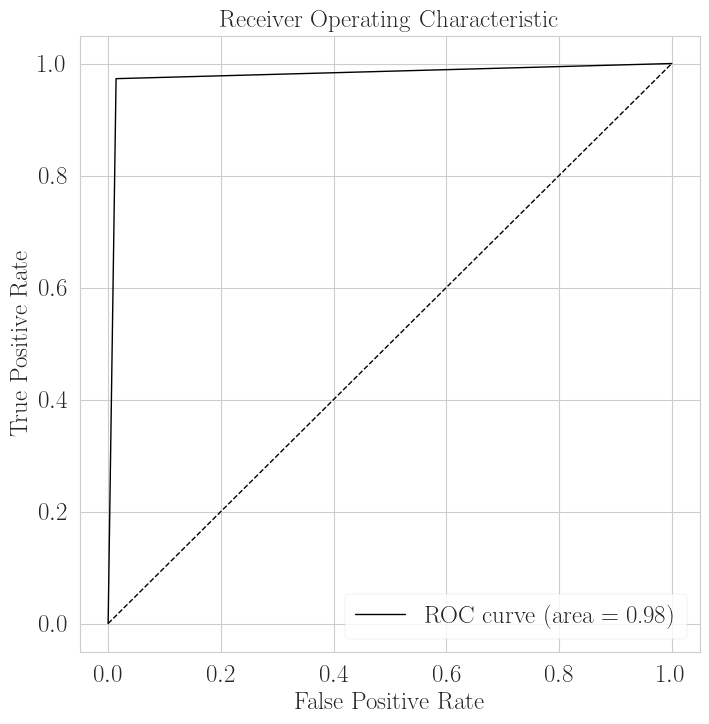

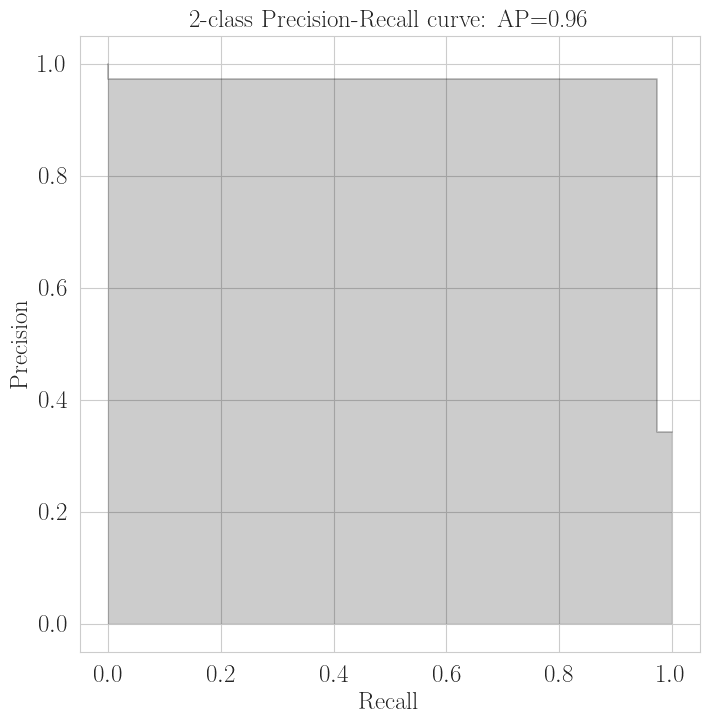

In [7]:
metrics.classification_summary(y_test, y_pred)
metrics.roc_curve(y_test, y_pred, save=True, save_to='../src/output_plots/NN_roc_curve.pdf')
metrics.precision_recall_curve(y_test, y_pred, save=True, save_to='../src/output_plots/NN_precision_recall_curve.pdf')

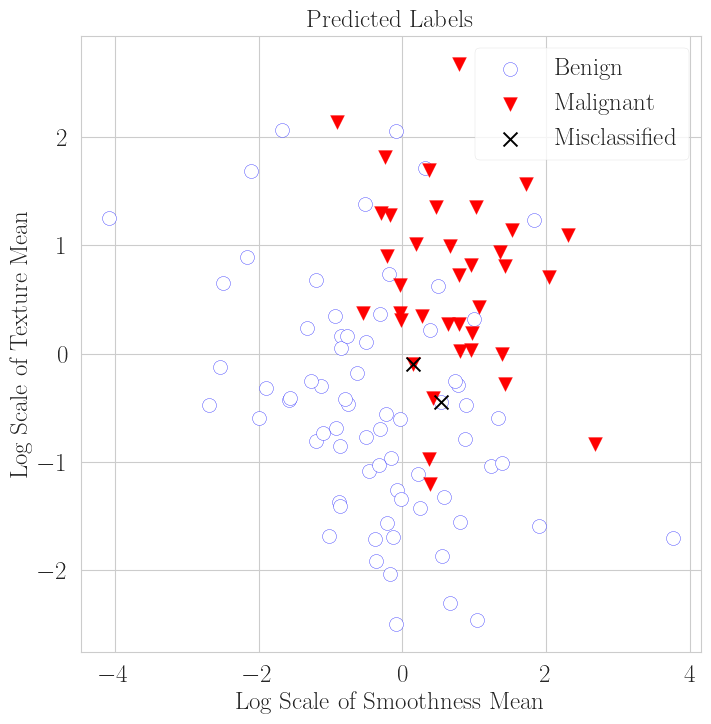

In [8]:
plt.subplots(figsize=(8, 8))
plt.title('Predicted Labels')
plt.scatter(X_test[y_pred == 0]['smoothness_mean_log'], X_test[y_pred == 0]['texture_mean_log'], marker='o',
            label='Benign', s=100, edgecolors='blue', facecolors='white')
plt.scatter(X_test[y_pred == 1]['smoothness_mean_log'], X_test[y_pred == 1]['texture_mean_log'], marker='v',
            label='Malignant', s=100, edgecolors='red', facecolors='red')
plt.scatter(X_test[y_pred != y_test]['smoothness_mean_log'], X_test[y_pred != y_test]['texture_mean_log'],
            marker='x',
            label='Misclassified', s=100, edgecolors='black', facecolors='black')
plt.xlabel('Log Scale of Smoothness Mean')
plt.ylabel('Log Scale of Texture Mean')
plt.legend()
plt.show()

In [9]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = NeuralNet(hidden_size=100, num_classes=2, num_epochs=100, batch_size=16, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(metrics.accuracy(y_test, y_pred))
print(accuracies)
print('Cross validation accuracy: {:.2f}'.format(np.mean(accuracies)))

Epoch [10/100], Loss: 0.0524
Epoch [20/100], Loss: 0.0227
Epoch [30/100], Loss: 0.0147
Epoch [40/100], Loss: 0.0113
Epoch [50/100], Loss: 0.0094
Epoch [60/100], Loss: 0.0081
Epoch [70/100], Loss: 0.0073
Epoch [80/100], Loss: 0.0065
Epoch [90/100], Loss: 0.0060
Epoch [100/100], Loss: 0.0057
Epoch [10/100], Loss: 0.0592
Epoch [20/100], Loss: 0.0222
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0111
Epoch [50/100], Loss: 0.0092
Epoch [60/100], Loss: 0.0080
Epoch [70/100], Loss: 0.0071
Epoch [80/100], Loss: 0.0065
Epoch [90/100], Loss: 0.0060
Epoch [100/100], Loss: 0.0056
Epoch [10/100], Loss: 0.0965
Epoch [20/100], Loss: 0.0453
Epoch [30/100], Loss: 0.0312
Epoch [40/100], Loss: 0.0257
Epoch [50/100], Loss: 0.0209
Epoch [60/100], Loss: 0.0179
Epoch [70/100], Loss: 0.0157
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0124
Epoch [100/100], Loss: 0.0112
Epoch [10/100], Loss: 0.0332
Epoch [20/100], Loss: 0.0139
Epoch [30/100], Loss: 0.0091
Epoch [40/100], Loss: 0.0069
Epoch [50/1

In [10]:
# Visualize neural network
from torchviz import make_dot
# Convert data to tensor
X_train = torch.from_numpy(X_train.values).float()
y_train = torch.from_numpy(y_train.values).long()

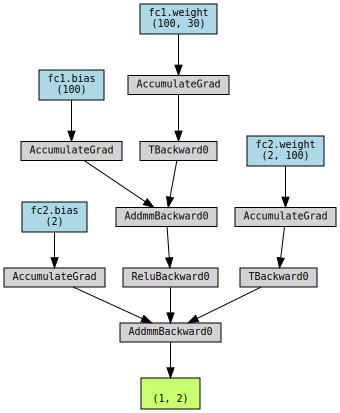

In [11]:
make_dot(model(X_train[:1]), params=dict(model.named_parameters()))

In [12]:
# Visualize the model
from torchsummary import summary
summary(model, (30,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           3,100
            Linear-2                    [-1, 2]             202
Total params: 3,302
Trainable params: 3,302
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
